Install fastai lib:

In [228]:
!pip3 install fastai

Install PyTorch:

In [229]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

  Using cached Pillow-5.0.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


Correct version of PIL:

In [230]:
!pip3 uninstall -y Pillow

Uninstalling Pillow-5.0.0:
  Successfully uninstalled Pillow-5.0.0


In [231]:
!pip3 install Pillow==4.0.0

  Using cached Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl


Get rossmann data:

In [232]:
!wget http://files.fast.ai/part2/lesson14/rossmann.tgz

--2018-03-16 14:12:22--  http://files.fast.ai/part2/lesson14/rossmann.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7730448 (7.4M) [text/plain]
Saving to: ‘rossmann.tgz.2’

rossmann.tgz.2      100%[===================>]   7.37M  10.3MB/s    in 0.7s    

2018-03-16 14:12:23 (10.3 MB/s) - ‘rossmann.tgz.2’ saved [7730448/7730448]



In [233]:
!tar -xvzf rossmann.tgz -C data/rossmann/

googletrend.csv
sample_submission.csv
state_names.csv
store.csv
store_states.csv
test.csv
train.csv
weather.csv


In [234]:
!ls data/rossmann

df		 models			store_states.csv  weather.csv
googletrend.csv  sample_submission.csv	test.csv
joined		 state_names.csv	tmp
joined_test	 store.csv		train.csv


# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [0]:
%matplotlib inline
#%reload_ext autoreload
#%autoreload 2

In [0]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/rossmann/'

## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

In [0]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

In [0]:
# concat_csvs('googletrend')
# concat_csvs('weather')

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [0]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [0]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [0]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [242]:
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [243]:
for t in tables: display(DataFrameSummary(t).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,Saarland,SL
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [0]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [245]:
len(train),len(test)

(1017209, 41088)

We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [0]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [0]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Join weather/state names.

In [0]:
weather = join_df(weather, state_names, "file", "StateName")

In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [0]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [0]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

The Google trends data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.

In [0]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [252]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [253]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [254]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [255]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [256]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [0]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [0]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [0]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

We'll replace some erroneous / outlying data.

In [0]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [261]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates.

In [0]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [0]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [0]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1).astype(int))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [0]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [0]:
df = train[columns]

In [0]:
df = test[columns]

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [0]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We'll do this for two more fields.

In [0]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We're going to set the active index to Date.

In [0]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [0]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [0]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [0]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [0]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [0]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [0]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [0]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [0]:
df.drop(columns,1,inplace=True)

In [282]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,-9223372036854775808,-9223372036854775808,-9223372036854775808,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,-9223372036854775808,-9223372036854775808,-9223372036854775808,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,-9223372036854775808,-9223372036854775808,-9223372036854775808,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,-9223372036854775808,-9223372036854775808,-9223372036854775808,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,-9223372036854775808,-9223372036854775808,-9223372036854775808,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [0]:
df.to_feather(f'{PATH}df')

In [0]:
df = pd.read_feather(f'{PATH}df')

In [0]:
df["Date"] = pd.to_datetime(df.Date)

In [286]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [0]:
joined = join_df(joined, df, ['Store', 'Date'])

In [0]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [0]:
joined = joined[joined.Sales!=0]

We'll back this up as well.

In [0]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [0]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features

In [0]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [293]:
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [294]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [0]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [0]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [0]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [0]:
apply_cats(joined_test, joined)

In [0]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

We're going to run on a sample.

In [300]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

To run on the full dataset, use this instead:

In [0]:
samp_size = n
joined_samp = joined.set_index("Date")

We can now process our data...

In [91]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015,7,31,False,24,0,c,a,...,24.0,11.0,1.0,85.0,83.0,NaN,NaN,1.0,1.0,5263
2015-07-31,2,5,2015,7,31,False,24,25,a,a,...,14.0,11.0,4.0,80.0,83.0,NaN,NaN,1.0,1.0,6064


In [0]:
joined_samp['AfterStateHoliday']=joined_samp['AfterStateHoliday'].fillna(0)
joined_samp['BeforeStateHoliday']=joined_samp['BeforeStateHoliday'].fillna(0)

In [0]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [0]:
joined_test = joined_test.set_index("Date")

In [0]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [307]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,3,7,31,1,25,1,3,1,...,-0.142774,-2.805667,1.732492,1.724334,0.0,0.0,1.113717,2.04105,-0.050948,-0.29609
2015-07-31,2,5,3,7,31,1,25,26,1,1,...,-0.142774,-0.961766,1.294578,1.724334,0.0,0.0,1.113717,2.04105,-0.050948,-0.29609


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [0]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [0]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [0]:
val_idx=[0]

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [0]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [0]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [0]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [214]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 1),
 ('Promo_bw', 1),
 ('StateHoliday_fw', 1),
 ('StateHoliday_bw', 1),
 ('SchoolHoliday_fw', 1),
 ('SchoolHoliday_bw', 1)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [0]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [216]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1)]

In [0]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [218]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 58%|█████▊    | 3795/6597 [01:02<00:46, 60.25it/s, loss=0.121]

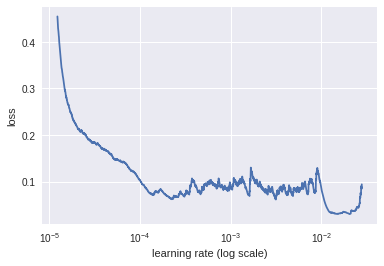

In [219]:
m.sched.plot(100)

### Sample

In [0]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [221]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


  0%|          | 22/6597 [00:01<07:48, 14.04it/s, loss=1.19]


  1%|          | 46/6597 [00:02<06:27, 16.90it/s, loss=0.578]


  1%|          | 69/6597 [00:03<06:08, 17.70it/s, loss=0.374]


  1%|▏         | 90/6597 [00:05<06:05, 17.80it/s, loss=0.261]


  2%|▏         | 113/6597 [00:06<05:54, 18.28it/s, loss=0.197]


  2%|▏         | 135/6597 [00:07<05:53, 18.31it/s, loss=0.148]


  2%|▏         | 146/6597 [00:07<05:52, 18.31it/s, loss=0.132]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[0.      0.01371 0.00018 0.01331]


[1.      0.01041 0.00002 0.00409]
[2.      0.01028 0.00914 0.09115]



In [222]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[0.      0.00767 0.      0.00034]
[1.      0.00733 0.      0.00111]


[2.      0.00705 0.00064 0.02572]


[3.      0.0071  0.00011 0.01055]
[4.      0.00724 0.00049 0.02251]



In [223]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

[0.      0.00805 0.00264 0.05275]
[1.      0.00743 0.0027  0.05335]


[2.      0.00629 0.00023 0.01529]
[3.      0.00588 0.00055 0.02363]


[4.      0.00721 0.00001 0.00235]
[5.      0.007   0.00147 0.03904]


[6.      0.00635 0.00011 0.01035]
[7.      0.00554 0.00107 0.03327]



### All

In [0]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [225]:
m.fit(lr, 1, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.      0.0141  0.00529 0.07545]



In [226]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.01123 0.00002 0.00391]
                                                                

[1.      0.01094 0.00595 0.07424]
[2.      0.00874 0.00076 0.02725]



In [227]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.00778 0.      0.00029]
[1.      0.00735 0.00023 0.01491]


[2.      0.00698 0.00058 0.02379]



### Test

In [0]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [0]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.01413  0.0063   0.07628]                           
[ 1.       0.01022  0.00859  0.08851]                           
[ 2.       0.00932  0.00001  0.00243]                            



In [0]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.00748  0.       0.00167]                            
[ 1.       0.00717  0.00009  0.00947]                            
[ 2.       0.00643  0.00013  0.01147]                            



In [0]:
m.save('val0')

In [0]:
m.load('val0')

In [0]:
x,y=m.predict_with_targs()

In [0]:
exp_rmspe(x,y)

0.01147316926177568

In [0]:
pred_test=m.predict(True)

In [0]:
pred_test = np.exp(pred_test)

In [0]:
joined_test['Sales']=pred_test

In [0]:
csv_fn=f'{PATH}tmp/sub.csv'

In [0]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [0]:
FileLink(csv_fn)

/home/ubuntu/fastai/courses/dl1/data/rossmann/tmp/sub.csv

## RF

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [0]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [0]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.98086411192483902,
 0.92614447508562714,
 0.9193358549649463,
 0.11557443993375387)